In [1]:
# Import required packages
import os 
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scienceplots
plt.style.use('science')

from scipy.stats import norm, truncnorm
from scipy.optimize import curve_fit
from scipy.special import erf

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy import units as u, constants as c

import corner
import emcee
from tqdm import tqdm
from multiprocessing import get_context, Pool

In [2]:
def shifted_truncated_normal(x, mu, sigma, a = -4, b = 4):
    """Define the truncated normal distribution."""
    phi = lambda x: (1 / np.sqrt(2 * np.pi)) * np.exp(- x * x / 2)
    psi = lambda x: 0.5 * (1 + erf(x / np.sqrt(2)))
    psi_norm = psi((b - mu) / sigma) - psi((a - mu) / sigma)
    return np.where((x >= a) & (x <= b), (1 / (psi_norm * sigma)) * phi((x - mu) / sigma), 0)
    

def ln_likelihood(theta, d_par_over_sigma, reported_error1, true_error2, a = -4, b = 4, truncate = True):
    """Compute log likelihood of observed uncertainty-normalized parallax differences."""
    f, mu = theta
    if f <= 0:
        return -np.inf
    mu_hat = mu / np.sqrt(reported_error1 ** 2 + true_error2 ** 2)
    sig2 = ((f * reported_error1) ** 2 + true_error2 ** 2) / (reported_error1 ** 2 + true_error2 ** 2)
    if truncate:
        L = shifted_truncated_normal(d_par_over_sigma, mu_hat, np.sqrt(sig2), a = a, b = b)
    else:
        L = (1 / np.sqrt(2 * np.pi * sig2)) * np.exp(-(d_par_over_sigma - mu_hat) ** 2 / (2 * sig2))
    with np.errstate(divide = 'ignore'):
        log_L = np.log(L)
    return np.sum(log_L)


def mcmc_estimator(xs, e1s, e2s, a = -4, b = 4, truncate = True, burn = 500, samples = 500, nwalkers = 64, 
                   f_init = 1, mu_init = 1e-4, progress_bool = False, plot = False):
    """Run MCMC analysis and derive best-fit parameters."""
    ndim, p0 = 2, [f_init, mu_init]
    p0 = np.tile(p0, (nwalkers, 1))
    p0 += p0 * 1e-10 * np.random.normal(size = (nwalkers, ndim))

    with get_context('fork').Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood, args = [xs, e1s, e2s, a, b, truncate], pool = pool)
        state = sampler.run_mcmc(p0, burn, progress = progress_bool)
        sampler.reset()
        state = sampler.run_mcmc(state, samples, progress = progress_bool)

    if plot:
        labels = [r'$f$', r'$\mu$']
        _ = corner.corner(sampler.flatchain, labels = labels, show_titles = True, plot_datapoints = False, 
                          plot_density = False, color = 'k', label_kwargs = {'fontsize': 20})   

    fs = sampler.flatchain[:, 0]
    ms = sampler.flatchain[:, 1]
    return np.median(fs), np.std(fs), np.median(ms), np.std(ms)

# Orbital Solutions

In [3]:
wide_astrometric_binaries = Table.read('astrometric_binaries_orbital_solutions.fits', format = 'fits', hdu = 1)
wab_tab = wide_astrometric_binaries.to_pandas()
print(wab_tab.info())
wab_tab.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7820 entries, 0 to 7819
Columns: 311 entries, source_id1 to goodness_of_fit2
dtypes: Int16(22), bool(24), float32(189), float64(33), int16(34), int64(6), object(3)
memory usage: 9.3+ MB
None


,source_id1,source_id2,ra1,ra2,dec1,dec2,pmra1,pmra2,pmdec1,pmdec2,...,ebpminrp_gspphot_upper2,binary_type,parallax1_5par,parallax_error1_5par,parallax2_5par,parallax_error2_5par,sol_type2,sol_type1,goodness_of_fit1,goodness_of_fit2
0,5912882958181910272,5912882958181907200,264.171862,264.173250,-58.946657,-58.951613,0.931138,0.946513,4.167048,4.190610,...,0.1112,b'MSMS',1.502496,0.026975,1.802252,0.041812,b'single_star',b'full_orbit',4.022071,NaN
1,2266488296897213568,2266488292601148672,276.476084,276.481878,71.731985,71.731144,2.337085,0.014297,49.181400,50.399051,...,0.0802,b'MSMS',8.585089,0.321890,8.357330,0.110459,b'single_star',b'full_orbit',0.989332,NaN
2,2270075453583492608,2270075449287650176,316.708033,316.710381,68.336235,68.337275,4.098409,4.362568,-5.608033,-5.182936,...,NaN,b'MSMS',1.549690,0.023879,1.758628,0.272565,b'single_star',b'full_orbit',0.472767,NaN
3,2264813981205935360,2264813981205934848,291.992491,291.988401,73.266190,73.265814,18.492288,20.010627,7.386946,7.912824,...,0.0294,b'MSMS',6.067444,0.040911,5.115934,0.072228,b'accel',b'full_orbit',6.136487,NaN
4,2268924745943999744,2268924745943999872,274.762215,274.768472,75.407641,75.405461,-6.574288,-6.555878,-9.518400,-9.562087,...,0.3263,b'MSMS',1.859441,0.029869,2.022609,0.066443,b'single_star',b'full_orbit',4.288877,NaN


In [4]:
# Distances (pc)
wab_dists = (1000 * u.pc) / wab_tab['parallax1'].values

# Angular separations (arcsec)
wab_ang_seps = (wab_tab['pairdistance'] * 3600).values

# Parallax differences (mas)
wab_parallax_diffs = (wab_tab['parallax1'] - wab_tab['parallax2']).values

In [5]:
check_near_wide = []
wab_unc_norm_parallax_diffs = []
wab_sigmas1, wab_sigmas2 = [], []

for i, row in wab_tab.iterrows():

    # Compute uncertainty-normalized parallax differences
    parallax_diff = row['parallax1'] - row['parallax2']
    sigma_1, sigma_2 = row['parallax_error1'], row['parallax_error2']
    wab_sigmas1.append(sigma_1)
    wab_sigmas2.append(sigma_2)
    sigma = np.sqrt(sigma_1 ** 2 + sigma_2 ** 2)
    wab_unc_norm_parallax_diffs.append(parallax_diff / sigma)

    # Estimate true parallax differences
    delta_parallax_true = (1 / 206265) * (wab_ang_seps[i] * wab_tab['parallax1'].values[i])
    check_near_wide.append(delta_parallax_true / sigma)

    # Filter out quadruple star candidates
    if not((row['sol_type1'].decode('utf8') == 'single_star') or (row['sol_type2'].decode('utf8') == 'single_star')):
        check_near_wide[-1] = 999

# Exclude triples whose physical size might contribute to parallax difference
check_near_wide = np.array(check_near_wide)
wab_sigmas1, wab_sigmas2 = np.array(wab_sigmas1)[check_near_wide < 0.05], np.array(wab_sigmas2)[check_near_wide < 0.05]
wab_unc_norm_parallax_diffs = np.array(wab_unc_norm_parallax_diffs)[check_near_wide < 0.05]

In [6]:
# Define bins for apparent G-band magnitude of primary
G_mag_bins = np.array([8, 10.5, 12, 13, 14, 16])
G_mag_primary_IDs = np.digitize(wab_tab['phot_g_mean_mag1'].values, G_mag_bins)
G_mag_secondary_IDs = np.digitize(wab_tab['phot_g_mean_mag2'].values, G_mag_bins)

# Constraints on apparent G-band magnitude of secondary in each bin
faint_bool_one = wab_tab['phot_g_mean_mag2'].values - wab_tab['phot_g_mean_mag1'].values < 0.5
faint_bool_two = (wab_tab['phot_g_mean_mag1'] < 10.5) & (wab_tab['phot_g_mean_mag2'] < 13)
faint_bool = (faint_bool_one | faint_bool_two)

# Exclude sources that fall outside the defined range
in_bin_bool = (G_mag_primary_IDs != 0) & (G_mag_primary_IDs != len(G_mag_bins)) & faint_bool
in_bin_bool = in_bin_bool[check_near_wide < 0.05]
G_mag_IDs = (G_mag_primary_IDs[check_near_wide < 0.05])[in_bin_bool]

# Require angular separation > 4 arcsec
ang_sep_bins = np.array([4, np.inf])
ang_sep_IDs = np.digitize(wab_ang_seps, ang_sep_bins)
ang_sep_IDs = ang_sep_IDs[check_near_wide < 0.05][in_bin_bool]

# Apply all filters
in_range_Gs = (wab_tab['phot_g_mean_mag1'].values[check_near_wide < 0.05])[in_bin_bool]
in_range_ang_seps = (wab_ang_seps[check_near_wide < 0.05])[in_bin_bool]
in_range_sigmas1, in_range_sigmas2 = wab_sigmas1[in_bin_bool], wab_sigmas2[in_bin_bool]
in_range_unc_norm_parallax_diffs = wab_unc_norm_parallax_diffs[in_bin_bool]

In [7]:
# Define cut on goodness-of-fit
gof_bool_one = (wab_tab['goodness_of_fit1'] < 5) & (wab_tab['phot_g_mean_mag1'] >= 13) 
gof_bool_two = (wab_tab['goodness_of_fit1'] < 10) & (wab_tab['phot_g_mean_mag1'] < 13) 
good_bool = (gof_bool_one | gof_bool_two)[check_near_wide < 0.05] & in_bin_bool

good_G_mag_IDs = (G_mag_primary_IDs[check_near_wide < 0.05])[good_bool]
good_ang_sep_IDs = (np.digitize(wab_ang_seps, ang_sep_bins)[check_near_wide < 0.05])[good_bool]

# Apply cut on goodness-of-fit
good_Gs = (wab_tab['phot_g_mean_mag1'].values[check_near_wide < 0.05])[good_bool]
good_ang_seps = (wab_ang_seps[check_near_wide < 0.05])[good_bool]
good_sigmas1, good_sigmas2 = wab_sigmas1[good_bool], wab_sigmas2[good_bool]
good_unc_norm_parallax_diffs = wab_unc_norm_parallax_diffs[good_bool]

In [8]:
# Use 5-parameter solutions instead of orbital solutions
five_par_sigmas1, five_par_sigmas2 = [], []
five_par_unc_norm_parallax_diffs = []
for i, row in wab_tab.iterrows():
    parallax_1, parallax_2 = row['parallax1_5par'], row['parallax2']
    sigma_1, sigma_2 = row['parallax_error1_5par'], row['parallax_error2']
    parallax_diff = parallax_1 - parallax_2
    five_par_sigmas1.append(sigma_1)
    five_par_sigmas2.append(sigma_2)
    sigma = np.sqrt(sigma_1 ** 2 + sigma_2 ** 2)
    five_par_unc_norm_parallax_diffs.append(parallax_diff / sigma)
        
five_par_sigmas1, five_par_sigmas2 = np.array(five_par_sigmas1)[check_near_wide < 0.05], np.array(five_par_sigmas2)[check_near_wide < 0.05]
five_par_unc_norm_parallax_diffs = np.array(five_par_unc_norm_parallax_diffs)[check_near_wide < 0.05]

in_range_five_par_sigmas1, in_range_five_par_sigmas2 = five_par_sigmas1[in_bin_bool], five_par_sigmas2[in_bin_bool]
in_range_five_par_unc_norm_parallax_diffs = five_par_unc_norm_parallax_diffs[in_bin_bool]

In [9]:
def plot_gaussians(parallax_diffs, sigmas1, sigmas2, G_mag_bins, ang_sep_bins, G_mag_IDs, ang_sep_IDs, 
                   a = -4, b = 4, text_str = None, truncate = True, plot_MCMC = False):
    """Helper function for plotting Gaussian distributions."""
    gaussian_lins = np.linspace(a, b, 100)
    fig, axes = plt.subplots(len(G_mag_bins) - 1, len(ang_sep_bins) - 1, figsize = (12, 20), sharex = True, sharey = True,
                             layout = 'constrained')
    axes.shape = (len(G_mag_bins) - 1, len(ang_sep_bins) - 1)

    all_fs, all_f_errs = [], []
    all_mus, all_mu_errs = [], []
    
    for j in range(1, len(ang_sep_bins)):
        
        fs, f_errs = [], []
        mus, mu_errs = [], []
        
        for i in tqdm(range(1, len(G_mag_bins))):
            
            curr_ax = axes[i - 1][j - 1]
            curr_bool = (G_mag_IDs == i) & (ang_sep_IDs == j)
            unpds = parallax_diffs[curr_bool]
            errs1, errs2 = sigmas1[curr_bool], sigmas2[curr_bool]

            # Plot observed distribution of uncertainty-normalized parallax differences
            _ = curr_ax.hist(unpds, density = True, histtype = 'step', color = 'royalblue', linewidth = 3)

            # Derive best-fit parameters
            f, f_err, mu, mu_err = mcmc_estimator(unpds, errs1, errs2, a = a, b = b, truncate = truncate, plot = plot_MCMC)
            fs.append(f)
            f_errs.append(f_err)
            mus.append(mu)
            mu_errs.append(mu_err)

            # Compute median mean and standard deviation in each bin
            median_mu_hat = mu / np.median(np.sqrt(errs1 ** 2 + errs2 ** 2))
            median_sigma = np.median(np.sqrt(((f * errs1) ** 2 + errs2 ** 2) / (errs1 ** 2 + errs2 ** 2)))

            # Plot best-fit Gaussian distribution
            if truncate:
                best_fit_curve = truncnorm.pdf(gaussian_lins, a, b, loc = median_mu_hat, scale = median_sigma)
            else:
                best_fit_curve = norm.pdf(gaussian_lins, loc = median_mu_hat, scale = median_sigma)
                
            curr_ax.plot(gaussian_lins, best_fit_curve, color = 'black', lw = 2, label = rf'$f = {f:.2f}$')
            curr_ax.plot(gaussian_lins, norm.pdf(gaussian_lins, loc = 0, scale = 1), color = 'black', lw = 2, dashes = [5, 5])
            
            if ang_sep_bins[j] == np.inf:
                title_str = rf'${G_mag_bins[i - 1]} < G < {G_mag_bins[i]}$; $\theta ["] > {ang_sep_bins[j - 1]}$'
            else:
                title_str = rf'${G_mag_bins[i - 1]} < G < {G_mag_bins[i]}$; ${ang_sep_bins[j - 1]} < \theta ["] < {ang_sep_bins[j]}$'
                
            curr_ax.set_title(title_str, fontsize = 28)
            curr_ax.tick_params(which = 'both', labelsize = 28, pad = 10)
            curr_ax.set_xlim(a, b)
            curr_ax.text(0.05, 0.85, rf'$N = {len(unpds)}$', fontsize = 28, transform = curr_ax.transAxes)
            curr_ax.legend(fontsize = 28)
            
        all_fs.append(fs)
        all_f_errs.append(f_errs)
        all_mus.append(mus)
        all_mu_errs.append(mu_errs)

    if text_str is not None:
        axes[0][0].text(0.05, 0.7, text_str, fontsize = 28, transform = axes[0][0].transAxes)

    for lax in axes[:, 0]:
        lax.set_ylabel(r'$p(\Delta\varpi/\sigma_{\Delta\varpi})$', fontsize = 28)

    for bax in axes[-1]:
        bax.set_xlabel(r'$\Delta\varpi/\sigma_{\Delta\varpi}$', fontsize = 28)
    return fig, all_fs, all_f_errs, all_mus, all_mu_errs

100%|█████████████████████████████████████████████| 5/5 [00:10<00:00,  2.12s/it]


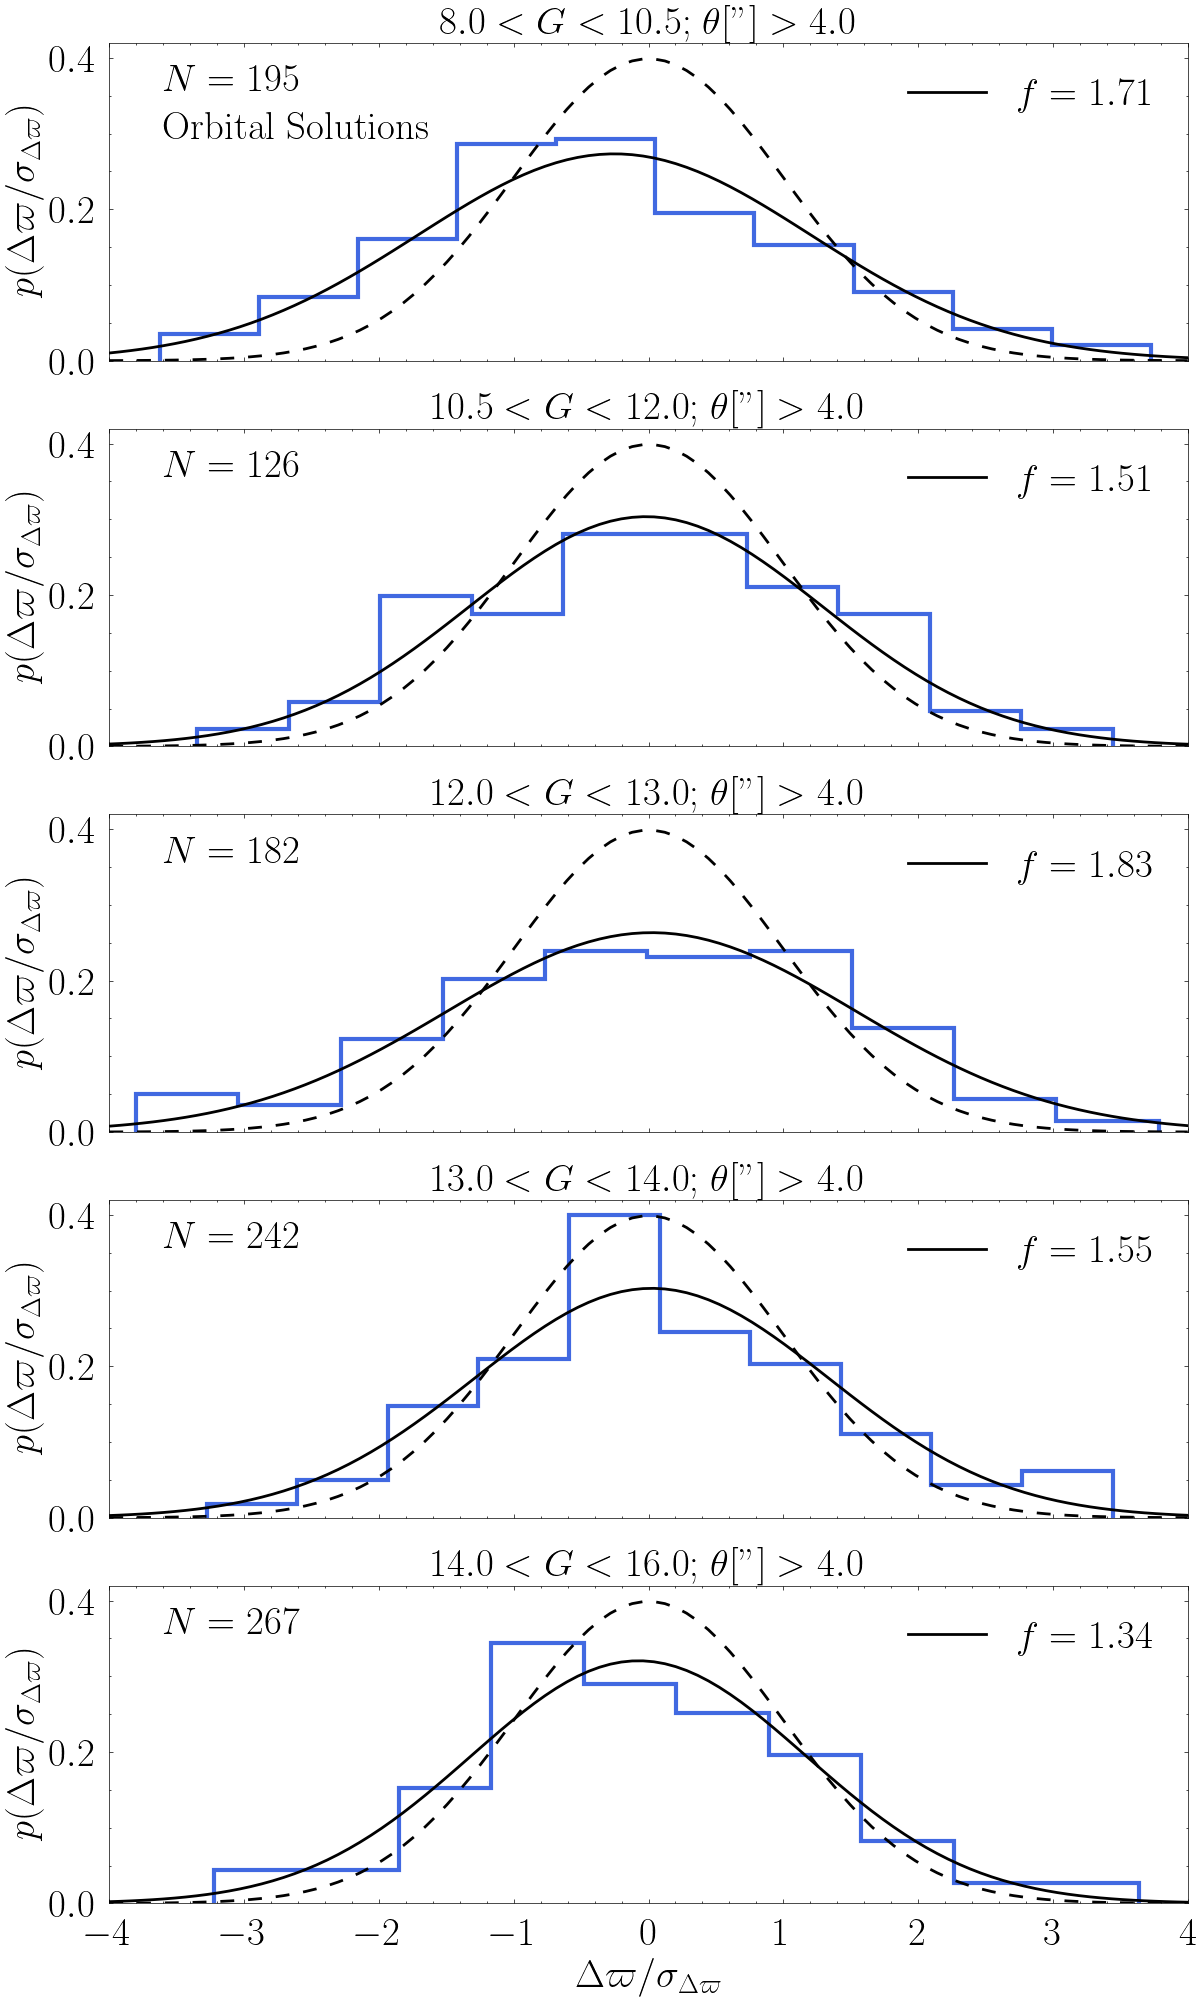

In [10]:
# Plot Gaussian distributions for hiearchical triples hosting unresolved astrometric binaries with orbital solutions
unpd_fig, all_fs, all_f_errs, all_mus, all_mu_errs = plot_gaussians(in_range_unc_norm_parallax_diffs, in_range_sigmas1, in_range_sigmas2, 
                                                                    G_mag_bins, ang_sep_bins, G_mag_IDs, ang_sep_IDs, 
                                                                    text_str = 'Orbital Solutions')

100%|█████████████████████████████████████████████| 5/5 [00:10<00:00,  2.10s/it]


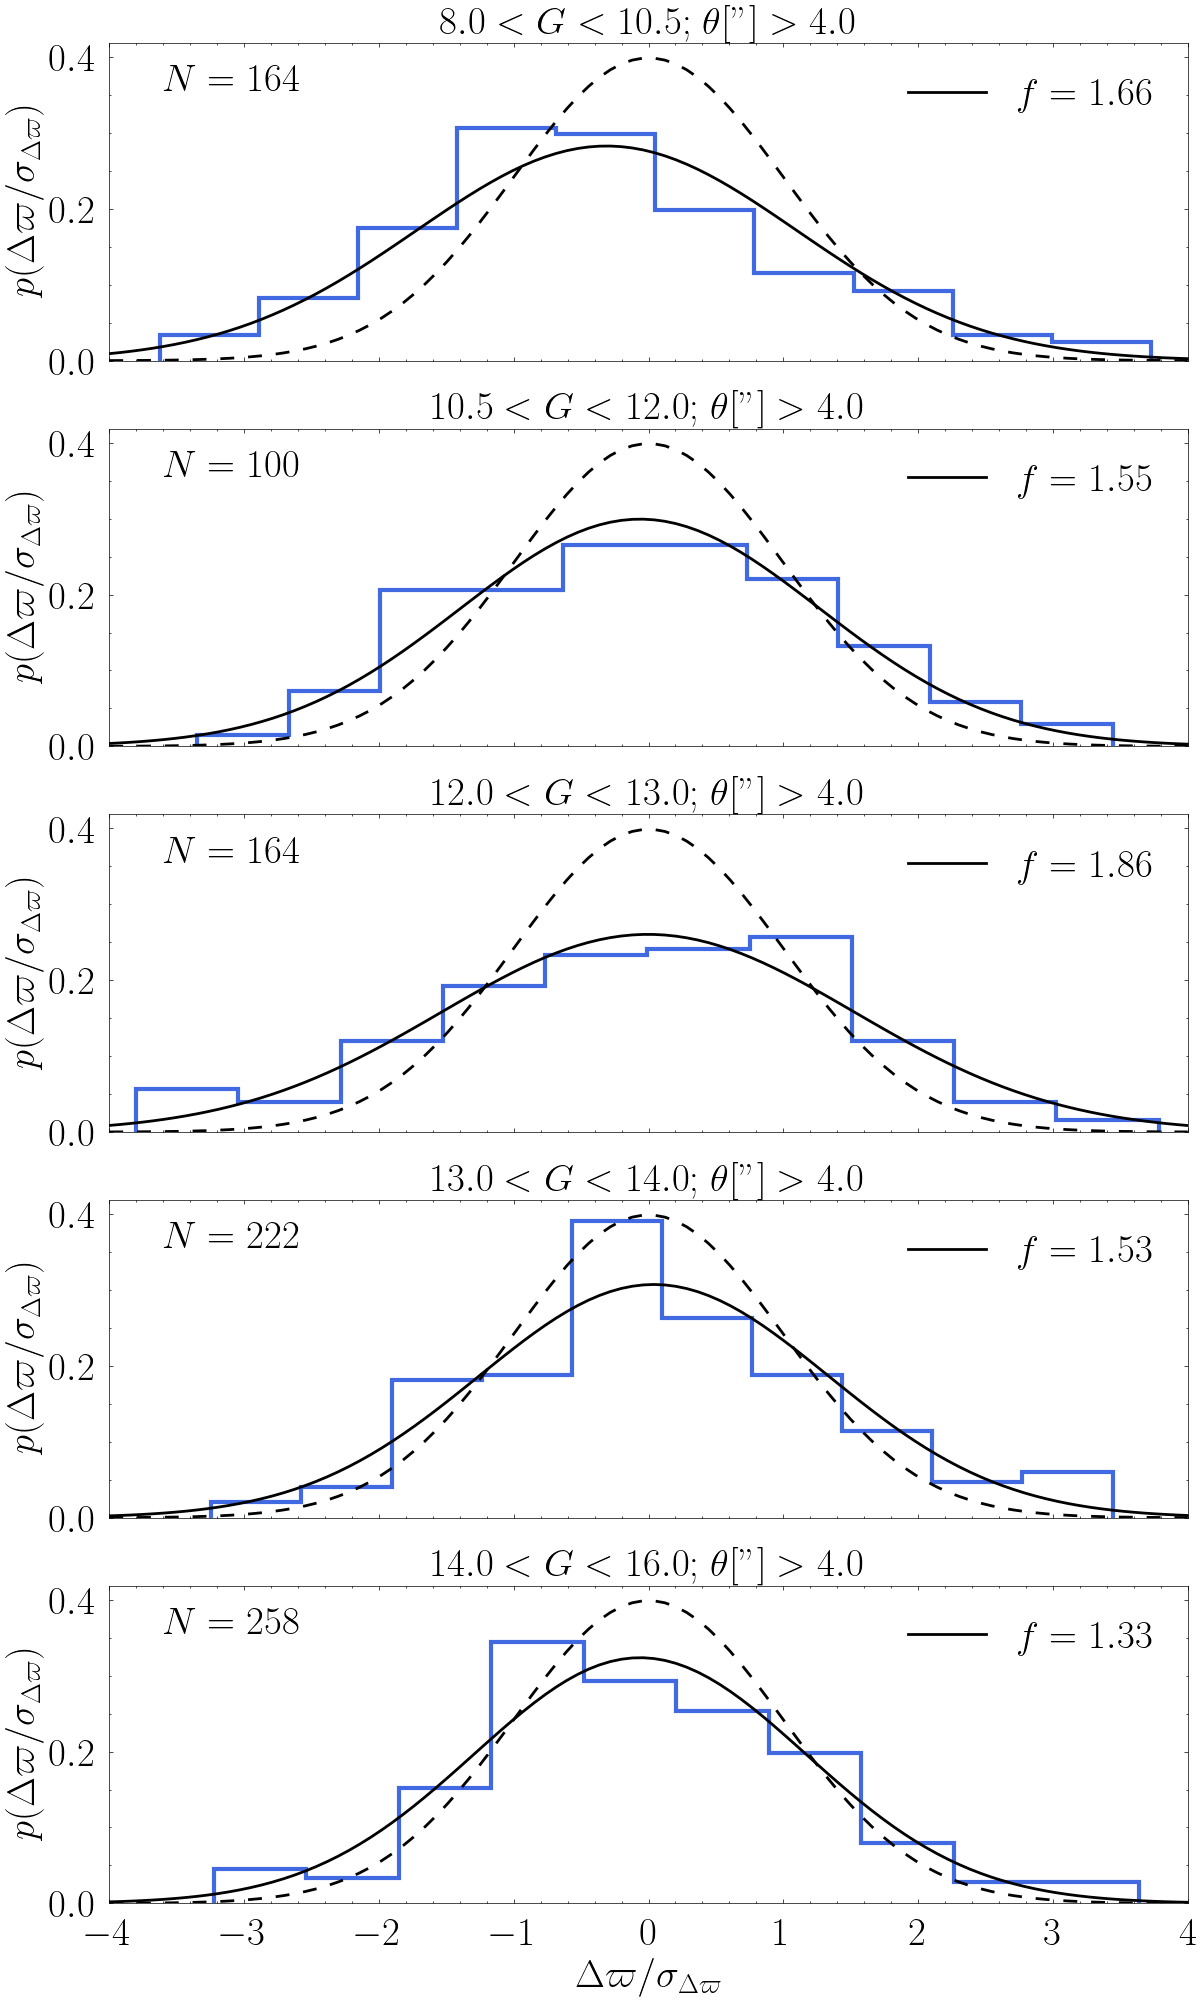

In [11]:
# Repeat with cuts on goodness-of-fit
good_unpd_fig, all_good_fs, all_good_f_errs, all_good_mus, all_good_mu_errs = plot_gaussians(good_unc_norm_parallax_diffs, 
                                                                                                     good_sigmas1, good_sigmas2, 
                                                                                                     G_mag_bins, ang_sep_bins,
                                                                                                     good_G_mag_IDs, good_ang_sep_IDs)

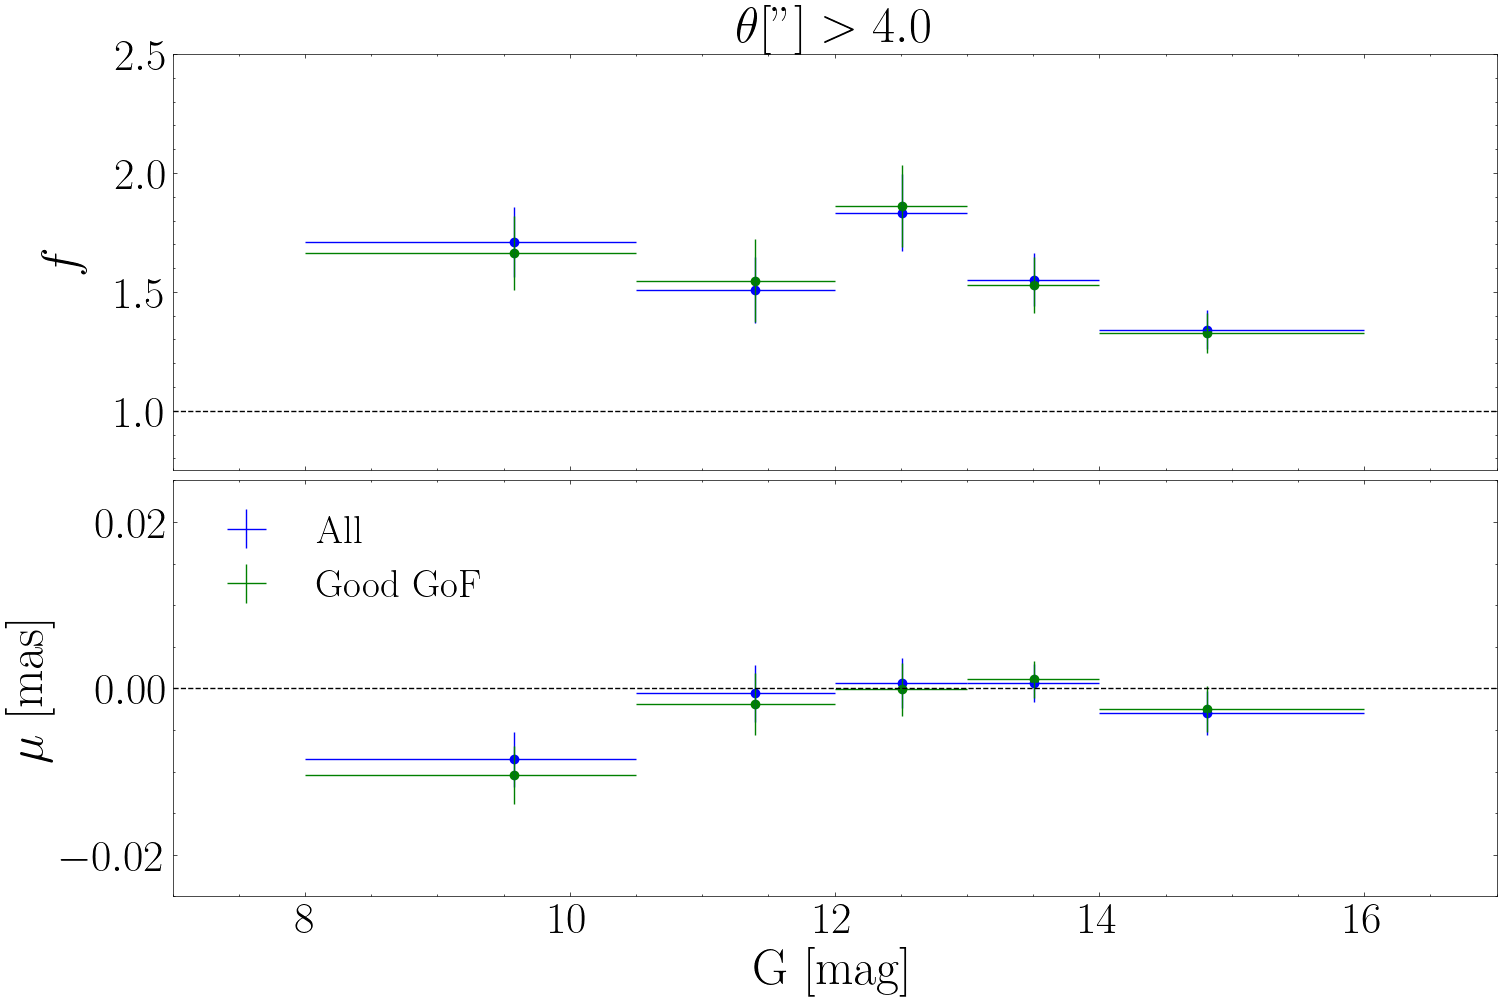

In [12]:
# Plot best-fit parameters as a function of apparent G-band magnitude
good_trend_fig, axes = plt.subplots(2, len(ang_sep_bins) - 1, figsize = (15, 10), sharex = True, sharey = 'row', layout = 'constrained')
axes = [[ax] for ax in axes]

for j in range(1, len(ang_sep_bins)):
    if ang_sep_bins[j] == np.inf:
        title_str = rf'$\theta ["] > {ang_sep_bins[j - 1]}$'
    else:
        title_str = rf'${ang_sep_bins[j - 1]} < \theta ["] < {ang_sep_bins[j]}$'
    curr_ax = axes[0][j - 1]
    mean_Gs, G_errs = [], []
    for i in range(1, len(G_mag_bins)):
        bin_Gs = in_range_Gs[(ang_sep_IDs == j) & (G_mag_IDs == i)]
        mean_Gs.append(np.mean(bin_Gs))
        G_errs.append([np.mean(bin_Gs) - G_mag_bins[i - 1], G_mag_bins[i] - np.mean(bin_Gs)])
    G_errs = np.array(G_errs)
    curr_ax.scatter(mean_Gs, all_fs[j - 1], color = 'blue')
    curr_ax.errorbar(mean_Gs, all_fs[j - 1], xerr = G_errs.T, yerr = all_f_errs[j - 1], linestyle = 'none', color = 'blue', 
                     label = 'All')
    curr_ax.scatter(mean_Gs, all_good_fs[j - 1], color = 'green')
    curr_ax.errorbar(mean_Gs, all_good_fs[j - 1], xerr = G_errs.T, yerr = all_good_f_errs[j - 1], linestyle = 'none', 
                     color = 'green', label = r'Good GoF')
    curr_ax.tick_params(which = 'both', labelsize = 32)
    curr_ax.set_title(title_str, fontsize = 36)
    curr_ax = axes[1][j - 1]
    curr_ax.scatter(mean_Gs, all_mus[j - 1], color = 'blue')
    curr_ax.errorbar(mean_Gs, all_mus[j - 1], xerr = G_errs.T, yerr = all_mu_errs[j - 1], linestyle = 'none', color = 'blue', 
                     label = 'All')
    curr_ax.scatter(mean_Gs, all_good_mus[j - 1], color = 'green')
    curr_ax.errorbar(mean_Gs, all_good_mus[j - 1], xerr = G_errs.T, yerr = all_good_mu_errs[j - 1], linestyle = 'none', 
                     color = 'green', label = r'Good GoF')
    curr_ax.tick_params(which = 'both', labelsize = 32)
    curr_ax.set_xlabel('G [mag]', fontsize = 36)

axes[0][0].set_xlim(7, 17)
axes[0][0].set_ylim(0.75, 2.5)
axes[0][0].hlines(1.0, axes[0][0].get_xlim()[0], axes[0][0].get_xlim()[1], linestyle = '--', color = 'black')

axes[1][0].set_ylim(-0.025, 0.025)
axes[1][0].hlines(0.0, axes[0][0].get_xlim()[0], axes[0][0].get_xlim()[1], linestyle = '--', color = 'black')

axes[0][0].set_ylabel(r'$f$', labelpad = 20, fontsize = 36)
axes[1][0].set_ylabel(r'$\mu$ [mas]', fontsize = 36)

axes[1][0].legend(fontsize = 28, loc = 'upper left');

100%|█████████████████████████████████████████████| 5/5 [00:10<00:00,  2.02s/it]


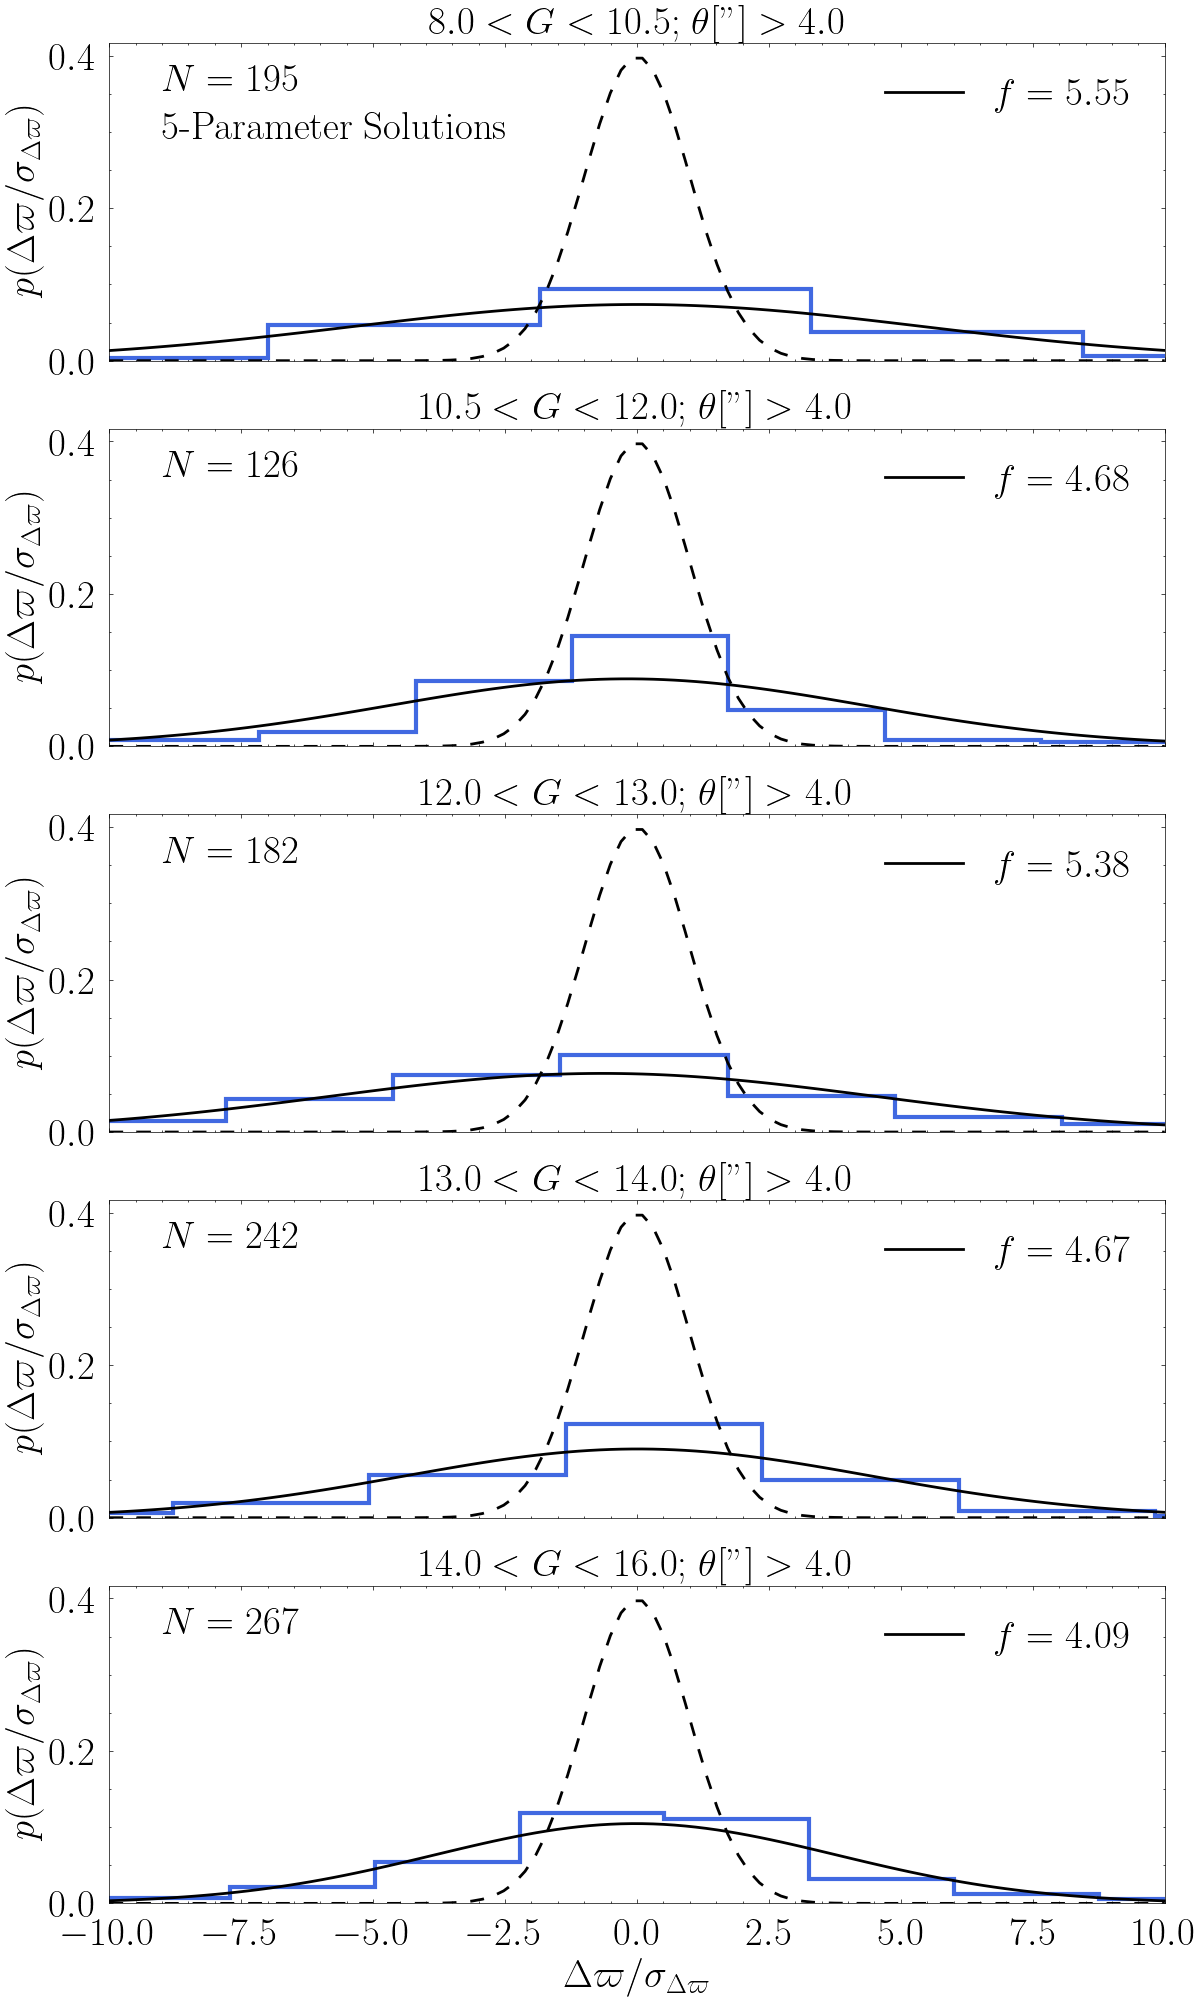

In [13]:
# Repeat with 5-parameter solutions in place of orbital solutions
five_par_result = plot_gaussians(in_range_five_par_unc_norm_parallax_diffs, in_range_five_par_sigmas1, 
                                 in_range_five_par_sigmas2, G_mag_bins, ang_sep_bins, G_mag_IDs, ang_sep_IDs, a = -10, b = 10, 
                                 truncate = False, text_str = '5-Parameter Solutions')
five_par_unpd_fig, all_five_par_fs, all_five_par_f_errs, all_five_par_mus, all_five_par_mu_errs = five_par_result

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 6195.43it/s]


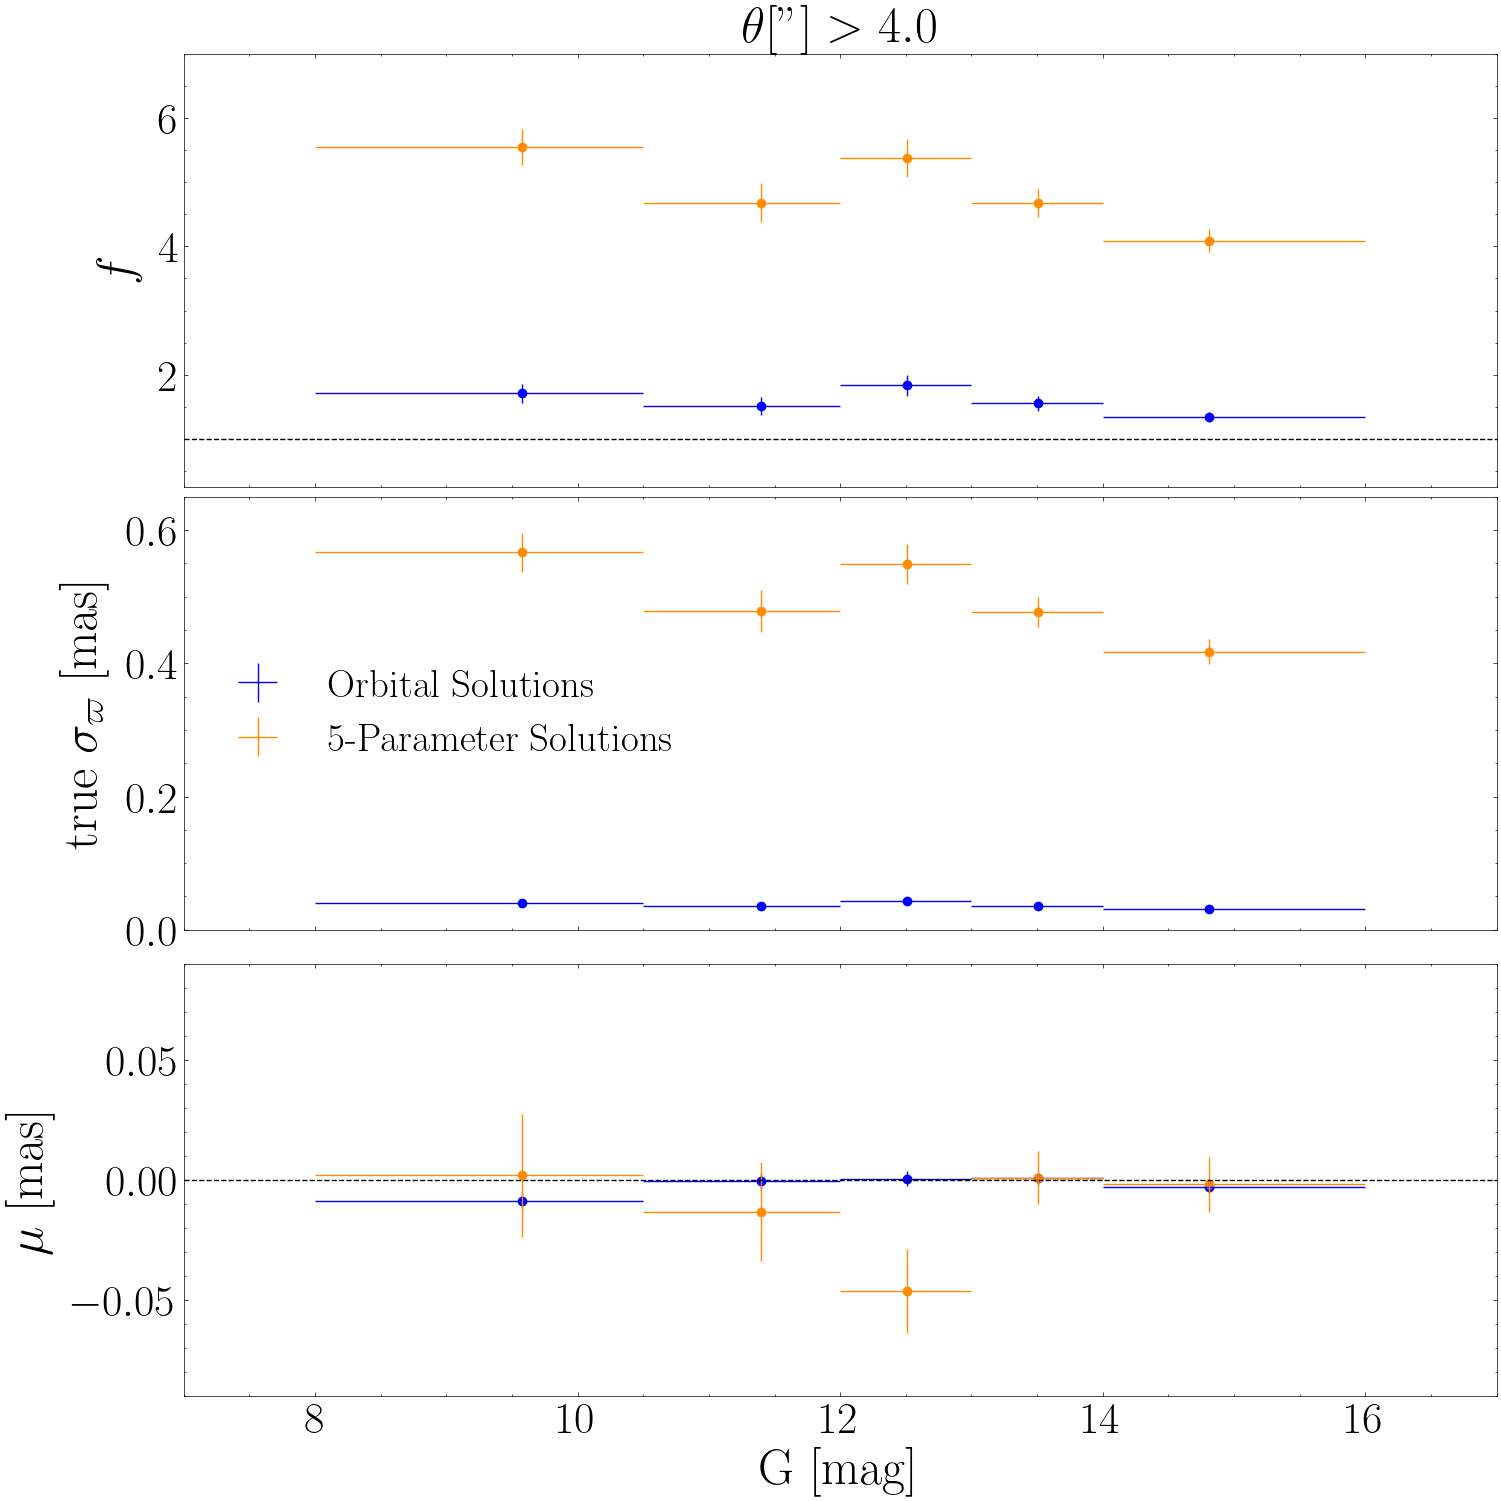

In [14]:
# Plot best-fit parameters and true uncertainties as a function of apparent G-band magnitude
five_par_trend_fig, axes = plt.subplots(3, len(ang_sep_bins) - 1, figsize = (15, 15), sharex = True, sharey = 'row', layout = 'constrained')
axes = [[ax] for ax in axes]

for j in range(1, len(ang_sep_bins)):
    if ang_sep_bins[j] == np.inf:
        title_str = rf'$\theta ["] > {ang_sep_bins[j - 1]}$'
    else:
        title_str = rf'${ang_sep_bins[j - 1]} < \theta ["] < {ang_sep_bins[j]}$'
        
    curr_ax = axes[0][j - 1]
    mean_Gs, G_errs = [], []
    for i in range(1, len(G_mag_bins)):
        bin_Gs = in_range_Gs[(ang_sep_IDs == j) & (G_mag_IDs == i)]
        mean_Gs.append(np.mean(bin_Gs))
        G_errs.append([np.mean(bin_Gs) - G_mag_bins[i - 1], G_mag_bins[i] - np.mean(bin_Gs)])
    G_errs = np.array(G_errs)
    curr_ax.scatter(mean_Gs, all_fs[j - 1], color = 'blue')
    curr_ax.errorbar(mean_Gs, all_fs[j - 1], xerr = G_errs.T, yerr = all_f_errs[j - 1], linestyle = 'none', color = 'blue', 
                     label = 'Orbital Solutions')
    curr_ax.scatter(mean_Gs, all_five_par_fs[j - 1], color = 'darkorange')
    curr_ax.errorbar(mean_Gs, all_five_par_fs[j - 1], xerr = G_errs.T, yerr = all_five_par_f_errs[j - 1], linestyle = 'none', 
                     color = 'darkorange', label = '5-Parameter Solutions')
    curr_ax.tick_params(which = 'both', labelsize = 32)
    curr_ax.set_title(title_str, fontsize = 36)

    curr_ax = axes[1][j - 1]
    median_sigmas1, median_five_par_sigmas1 = [], []
    for i in tqdm(range(1, len(G_mag_bins))):
        sigmas1 = in_range_sigmas1[(ang_sep_IDs == j) & (G_mag_IDs == i)]
        median_sigmas1.append(np.median(sigmas1))
        five_par_sigmas1 = in_range_five_par_sigmas1[(ang_sep_IDs == j) & (G_mag_IDs == i)]
        median_five_par_sigmas1.append(np.median(five_par_sigmas1))
    median_sigmas1 = np.array(median_sigmas1)
    median_five_par_sigmas1 = np.array(median_five_par_sigmas1)
    curr_ax.scatter(mean_Gs, np.array(all_fs[j - 1]) * median_sigmas1[j - 1], color = 'blue')
    curr_ax.errorbar(mean_Gs, np.array(all_fs[j - 1]) * median_sigmas1[j - 1], xerr = G_errs.T, 
                     yerr = np.array(all_f_errs[j - 1]) * median_sigmas1[j - 1], linestyle = 'none', color = 'blue', 
                     label = 'Orbital Solutions')
    curr_ax.scatter(mean_Gs, np.array(all_five_par_fs[j - 1]) * median_five_par_sigmas1[j - 1], color = 'darkorange')
    curr_ax.errorbar(mean_Gs, np.array(all_five_par_fs[j - 1]) * median_five_par_sigmas1[j - 1], xerr = G_errs.T, 
                     yerr = np.array(all_five_par_f_errs[j - 1]) * median_five_par_sigmas1[j - 1], linestyle = 'none', 
                     color = 'darkorange', label = '5-Parameter Solutions')
    curr_ax.tick_params(which = 'both', labelsize = 32)
    
    curr_ax = axes[2][j - 1]
    curr_ax.scatter(mean_Gs, all_mus[j - 1], color = 'blue')
    curr_ax.errorbar(mean_Gs, all_mus[j - 1], xerr = G_errs.T, yerr = all_mu_errs[j - 1], linestyle = 'none', color = 'blue', 
                     label = 'Orbital Solutions')
    curr_ax.scatter(mean_Gs, all_five_par_mus[j - 1], color = 'darkorange')
    curr_ax.errorbar(mean_Gs, all_five_par_mus[j - 1], xerr = G_errs.T, yerr = all_five_par_mu_errs[j - 1], linestyle = 'none', 
                     color = 'darkorange', label = '5-Parameter Solutions')
    curr_ax.tick_params(which = 'both', labelsize = 32)
    curr_ax.set_xlabel('G [mag]', fontsize = 36)

axes[0][0].set_xlim(7, 17)
axes[0][0].set_ylim(0.25, 7)
axes[0][0].hlines(1.0, axes[0][0].get_xlim()[0], axes[0][0].get_xlim()[1], linestyle = '--', color = 'black')

axes[1][0].set_ylim(0, 0.65)

axes[2][0].set_ylim(-0.09, 0.09)
axes[2][0].hlines(0.0, axes[0][0].get_xlim()[0], axes[0][0].get_xlim()[1], linestyle = '--', color = 'black')

axes[0][0].set_ylabel(r'$f$', labelpad = 12, fontsize = 36)
axes[1][0].set_ylabel(r'true $\sigma_{\varpi}$ [mas]', labelpad = 12, fontsize = 36)
axes[2][0].set_ylabel(r'$\mu$ [mas]', labelpad = 12, fontsize = 36)

axes[1][0].legend(fontsize = 28, loc = 'center left');

# Acceleration Solutions

In [15]:
accelerating_binaries = Table.read('astrometric_binaries_acceleration_solutions.fits', format = 'fits', hdu = 1)
acc_tab = accelerating_binaries.to_pandas()
print(acc_tab.info())
acc_tab.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6998 entries, 0 to 6997
Columns: 311 entries, source_id1 to goodness_of_fit2
dtypes: Int16(22), bool(24), float32(189), float64(33), int16(34), int64(6), object(3)
memory usage: 8.3+ MB
None


,source_id1,source_id2,ra1,ra2,dec1,dec2,pmra1,pmra2,pmdec1,pmdec2,...,ebpminrp_gspphot_upper2,binary_type,parallax1_5par,parallax_error1_5par,parallax2_5par,parallax_error2_5par,sol_type2,sol_type1,goodness_of_fit1,goodness_of_fit2
0,2266368003453172224,2266367900371768192,279.319750,279.317652,72.890445,72.889801,55.896591,57.263969,51.591233,50.815331,...,0.2472,b'MSMS',6.690250,0.035571,6.699933,0.025303,b'single_star',b'accel',4.716240,NaN
1,2270887305481783168,2270887305481783808,317.949158,317.952602,70.337347,70.337144,-31.334804,-31.753979,-22.880226,-21.828875,...,0.2774,b'MSMS',4.198393,0.023200,4.280287,0.065632,b'single_star',b'accel',-0.231517,NaN
2,2268388115550988928,2268388115550989056,285.477107,285.482551,75.836257,75.836438,2.879054,2.448498,1.325013,1.785933,...,0.1902,b'MSMS',2.694573,0.078420,2.870208,0.018856,b'single_star',b'accel',6.878868,NaN
3,2263259752801401600,2263259752802040320,296.377378,296.377989,70.983017,70.983442,13.290894,14.402727,10.944654,9.756249,...,NaN,b'MS??',2.726948,0.020158,2.672829,0.099459,b'single_star',b'accel',0.035289,NaN
4,2266512241338322816,2266512245634635392,274.782338,274.782949,71.465242,71.467798,4.478229,5.224896,-12.138591,-11.442333,...,0.2526,b'MSMS',4.902100,0.029936,4.997779,0.025869,b'single_star',b'accel',3.078955,NaN


In [16]:
# Distances (pc)
acc_dists = (1000 * u.pc) / acc_tab['parallax1'].values

# Angular separations (arcsec)
acc_ang_seps = (acc_tab['pairdistance'] * 3600).values

# Parallax differences (mas)
acc_parallax_diffs = (acc_tab['parallax1'] - acc_tab['parallax2']).values

In [17]:
check_acc_wide = []
acc_sigmas1, acc_sigmas2 = [], []
acc_unc_norm_parallax_diffs = []

for i, row in acc_tab.iterrows():

    # Compute uncertainty-normalized parallax differences
    parallax_diff = row['parallax1'] - row['parallax2']
    sigma_1, sigma_2 = row['parallax_error1'], row['parallax_error2']
    sigma = np.sqrt(sigma_1 ** 2 + sigma_2 ** 2)
    acc_sigmas1.append(sigma_1)
    acc_sigmas2.append(sigma_2)
    acc_unc_norm_parallax_diffs.append(parallax_diff / sigma)

    # Estimate true parallax differences
    delta_parallax_true = (1 / 206265) * (acc_ang_seps[i] * acc_tab['parallax1'].values[i])
    check_acc_wide.append(delta_parallax_true / sigma)

    # Remove quadruple star candidates
    if not((row['sol_type1'].decode('utf8') == 'single_star') or (row['sol_type2'].decode('utf8') == 'single_star')):
        check_acc_wide[-1] = 999

# Exclude triples whose physical size might contribute to parallax difference
check_acc_wide = np.array(check_acc_wide)
acc_sigmas1, acc_sigmas2 = np.array(acc_sigmas1)[check_acc_wide < 0.05], np.array(acc_sigmas2)[check_acc_wide < 0.05]
acc_unc_norm_parallax_diffs = np.array(acc_unc_norm_parallax_diffs)[check_acc_wide < 0.05]

In [18]:
# Define bins for apparent G-band magnitude of primary
acc_G_mag_bins = np.array([8, 13, 14, 16])
acc_primary_IDs = np.digitize(acc_tab['phot_g_mean_mag1'].values, acc_G_mag_bins)
acc_secondary_IDs = np.digitize(acc_tab['phot_g_mean_mag2'].values, acc_G_mag_bins)

# Constraints on apparent G-band magnitude of secondary in each bin
acc_faint_bool_one = acc_tab['phot_g_mean_mag2'].values - acc_tab['phot_g_mean_mag1'].values < 0.5
acc_faint_bool_two = (acc_tab['phot_g_mean_mag1'] < 12.5) & (acc_tab['phot_g_mean_mag2'] < 13)
acc_faint_bool = (acc_faint_bool_one | acc_faint_bool_two)

# Exclude sources that fall outside the defined range
acc_bin_bool = (acc_primary_IDs != 0) & (acc_primary_IDs != len(acc_G_mag_bins)) & acc_faint_bool
acc_bin_bool = acc_bin_bool[check_acc_wide < 0.05]
acc_G_mag_IDs = (acc_primary_IDs[check_acc_wide < 0.05])[acc_bin_bool]

# Require angular separation > 4 arcsec
acc_ang_sep_bins = np.array([4, np.inf])
acc_ang_sep_IDs = np.digitize(acc_ang_seps, acc_ang_sep_bins)
acc_ang_sep_IDs = (acc_ang_sep_IDs[check_acc_wide < 0.05])[acc_bin_bool]

# Apply all filters
acc_in_range_Gs = (acc_tab['phot_g_mean_mag1'].values[check_acc_wide < 0.05])[acc_bin_bool]
acc_in_range_ang_seps = (acc_ang_seps[check_acc_wide < 0.05])[acc_bin_bool]
acc_in_range_sigmas1, acc_in_range_sigmas2 = acc_sigmas1[acc_bin_bool], acc_sigmas2[acc_bin_bool]
acc_in_range_unc_norm_parallax_diffs = acc_unc_norm_parallax_diffs[acc_bin_bool]

In [19]:
# Use 5-parameter solutions instead of orbital solutions
acc_five_par_sigmas1, acc_five_par_sigmas2 = [], []
acc_five_par_unc_norm_parallax_diffs = []
for i, row in acc_tab.iterrows():
    parallax_1, parallax_2 = row['parallax1_5par'], row['parallax2']
    sigma_1, sigma_2 = row['parallax_error1_5par'], row['parallax_error2']
    parallax_diff = parallax_1 - parallax_2
    acc_five_par_sigmas1.append(sigma_1)
    acc_five_par_sigmas2.append(sigma_2)
    sigma = np.sqrt(sigma_1 ** 2 + sigma_2 ** 2)
    acc_five_par_unc_norm_parallax_diffs.append(parallax_diff / sigma)
    
acc_five_par_sigmas1, acc_five_par_sigmas2 = (np.array(acc_five_par_sigmas1)[check_acc_wide < 0.05], 
                                              np.array(acc_five_par_sigmas2)[check_acc_wide < 0.05])
acc_five_par_unc_norm_parallax_diffs = np.array(acc_five_par_unc_norm_parallax_diffs)[check_acc_wide < 0.05]

acc_in_range_five_par_sigmas1, acc_in_range_five_par_sigmas2 = acc_five_par_sigmas1[acc_bin_bool], acc_five_par_sigmas2[acc_bin_bool]
acc_in_range_five_par_unc_norm_parallax_diffs = acc_five_par_unc_norm_parallax_diffs[acc_bin_bool]

100%|█████████████████████████████████████████████| 3/3 [00:06<00:00,  2.12s/it]


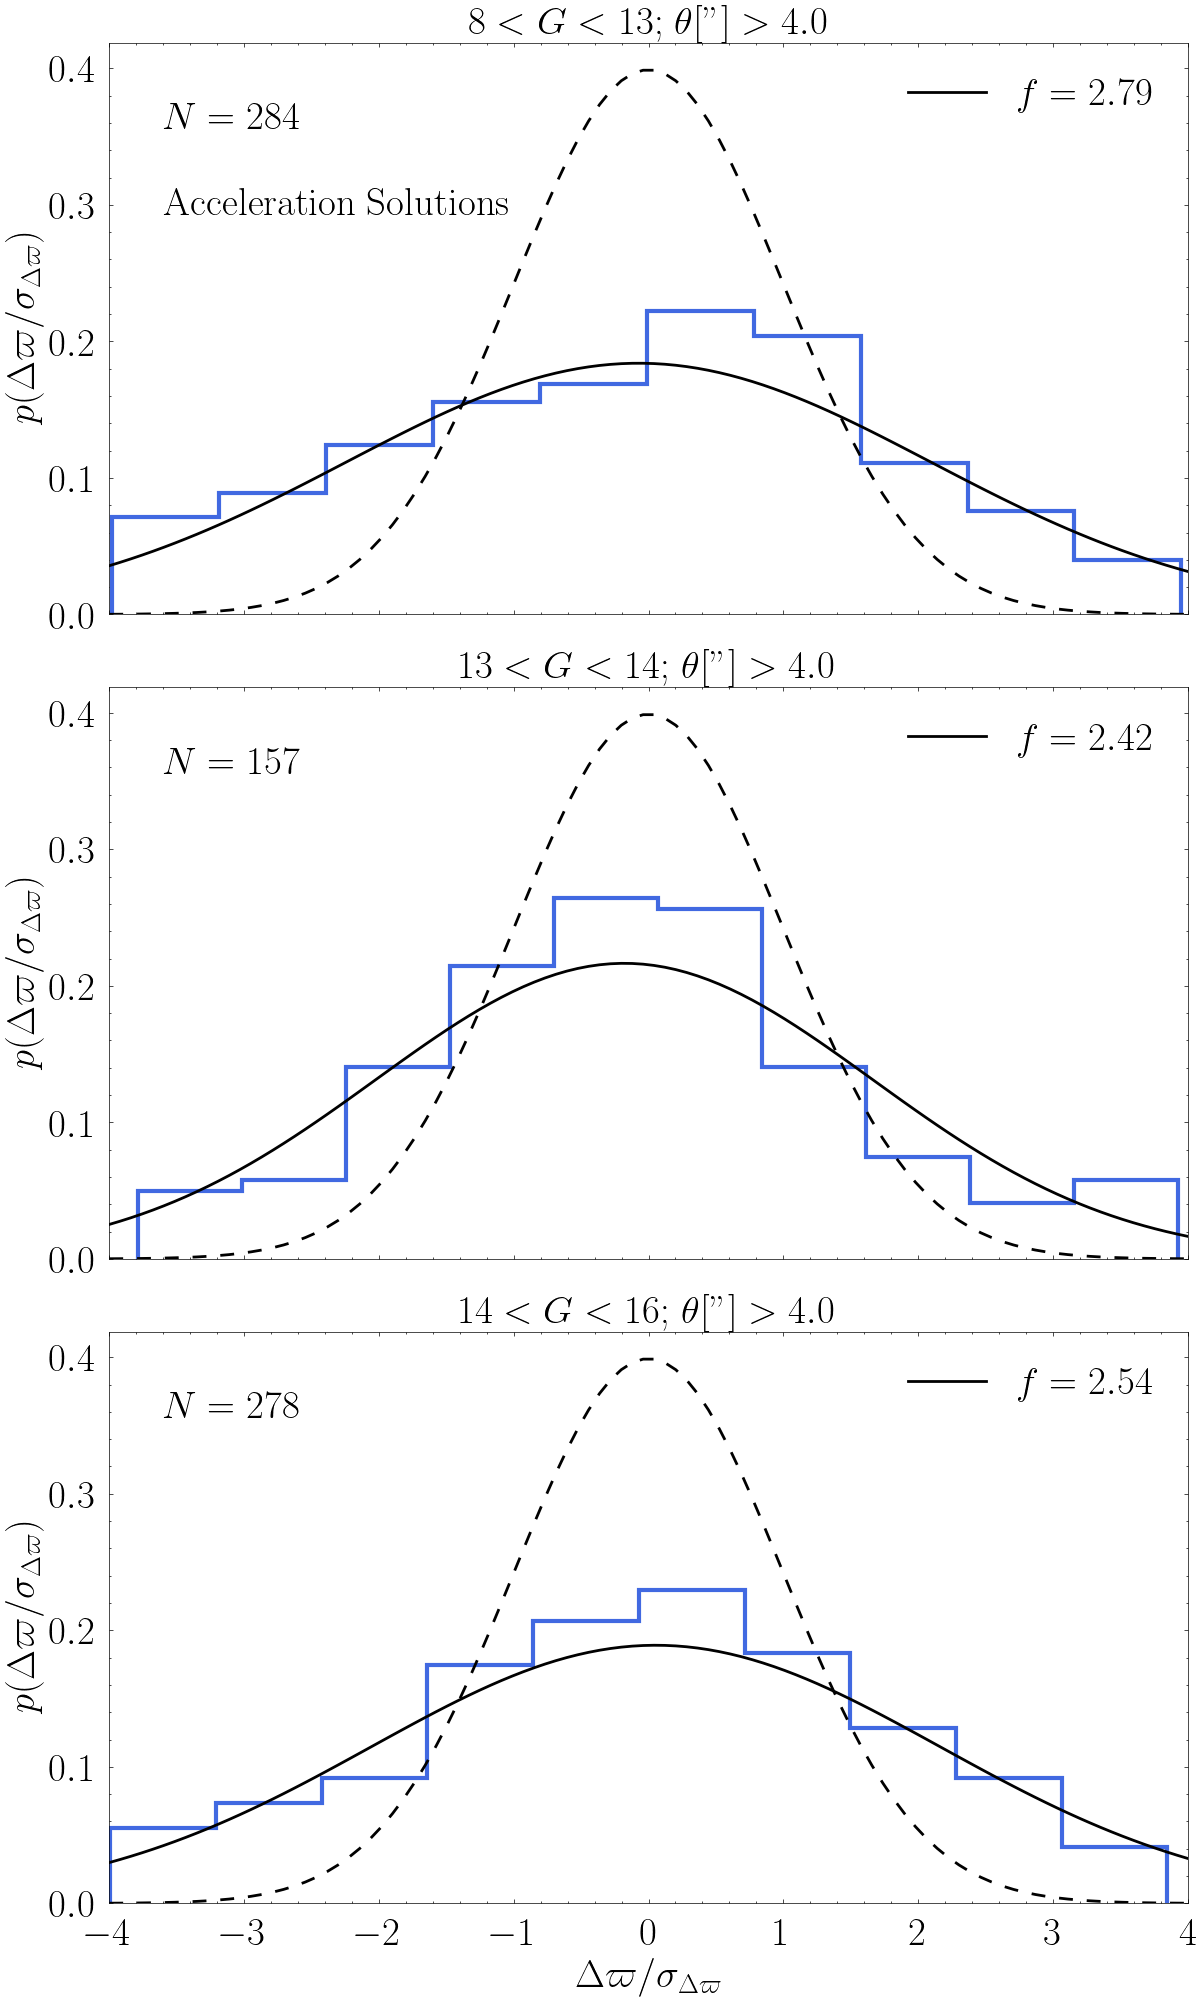

In [20]:
# Plot Gaussian distributions for hiearchical triples hosting unresolved astrometric binaries with acceleration solutions
acc_unpd_fig, all_acc_fs, all_acc_f_errs, all_acc_mus, all_acc_mu_errs = plot_gaussians(acc_in_range_unc_norm_parallax_diffs, 
                                                                                        acc_in_range_sigmas1, acc_in_range_sigmas2, 
                                                                                        acc_G_mag_bins, acc_ang_sep_bins,
                                                                                        acc_G_mag_IDs, acc_ang_sep_IDs,
                                                                                        text_str = 'Acceleration Solutions')

100%|█████████████████████████████████████████████| 3/3 [00:06<00:00,  2.05s/it]


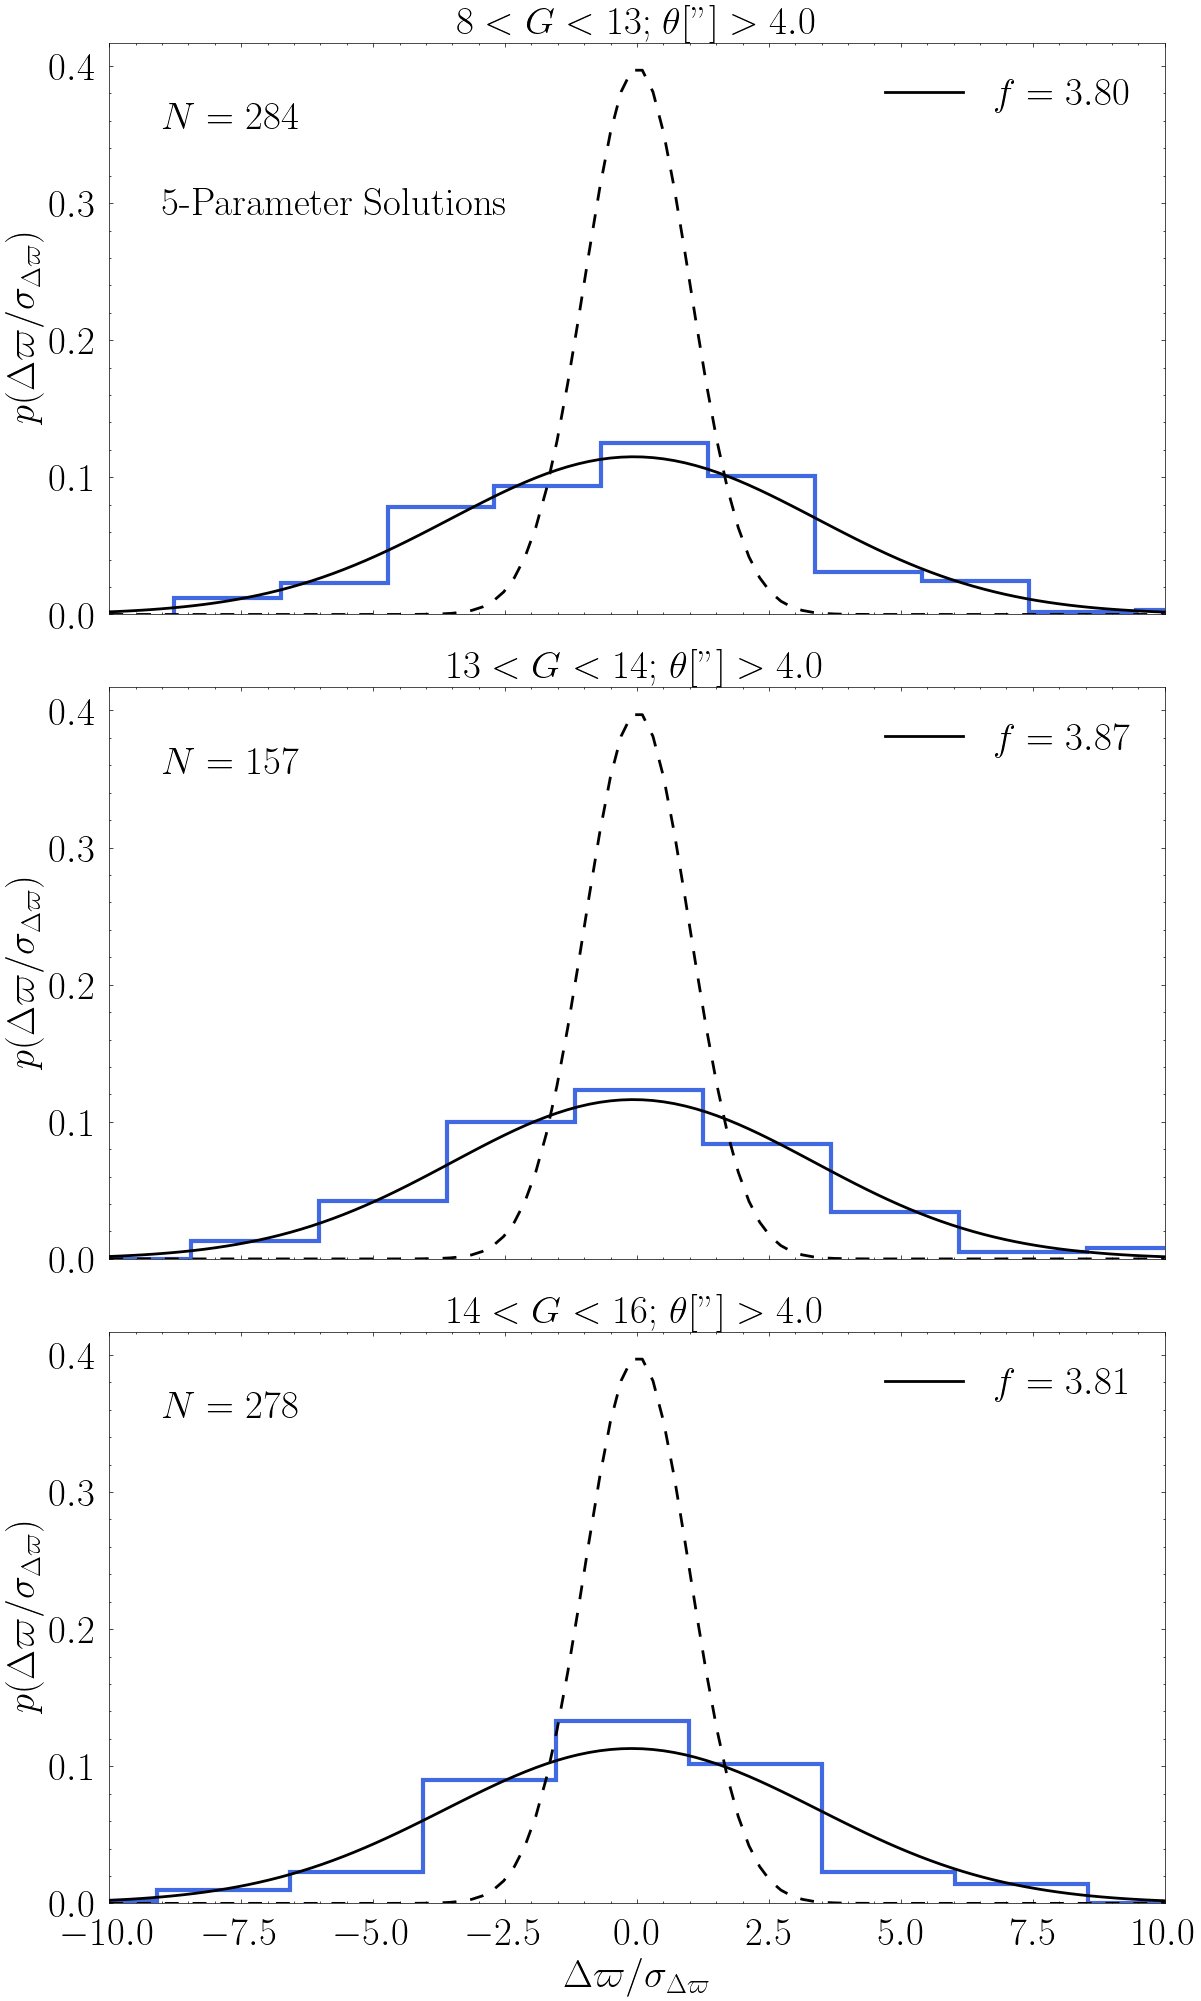

In [21]:
# Repeat with 5-parameter solutions in place of acceleration solutions
acc_five_result = plot_gaussians(acc_in_range_five_par_unc_norm_parallax_diffs, acc_in_range_five_par_sigmas1, 
                                 acc_in_range_five_par_sigmas2, acc_G_mag_bins, acc_ang_sep_bins, acc_G_mag_IDs, acc_ang_sep_IDs, 
                                 truncate = False, text_str = '5-Parameter Solutions', a = -10, b = 10)
acc_five_par_unpd_fig, all_acc_five_par_fs, all_acc_five_par_f_errs, all_acc_five_par_mus, all_acc_five_par_mu_errs = acc_five_result

  0%|                                                     | 0/5 [00:00<?, ?it/s]/Users/pranav/Graduate_School/defaultenv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/pranav/Graduate_School/defaultenv/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 4047.77it/s]


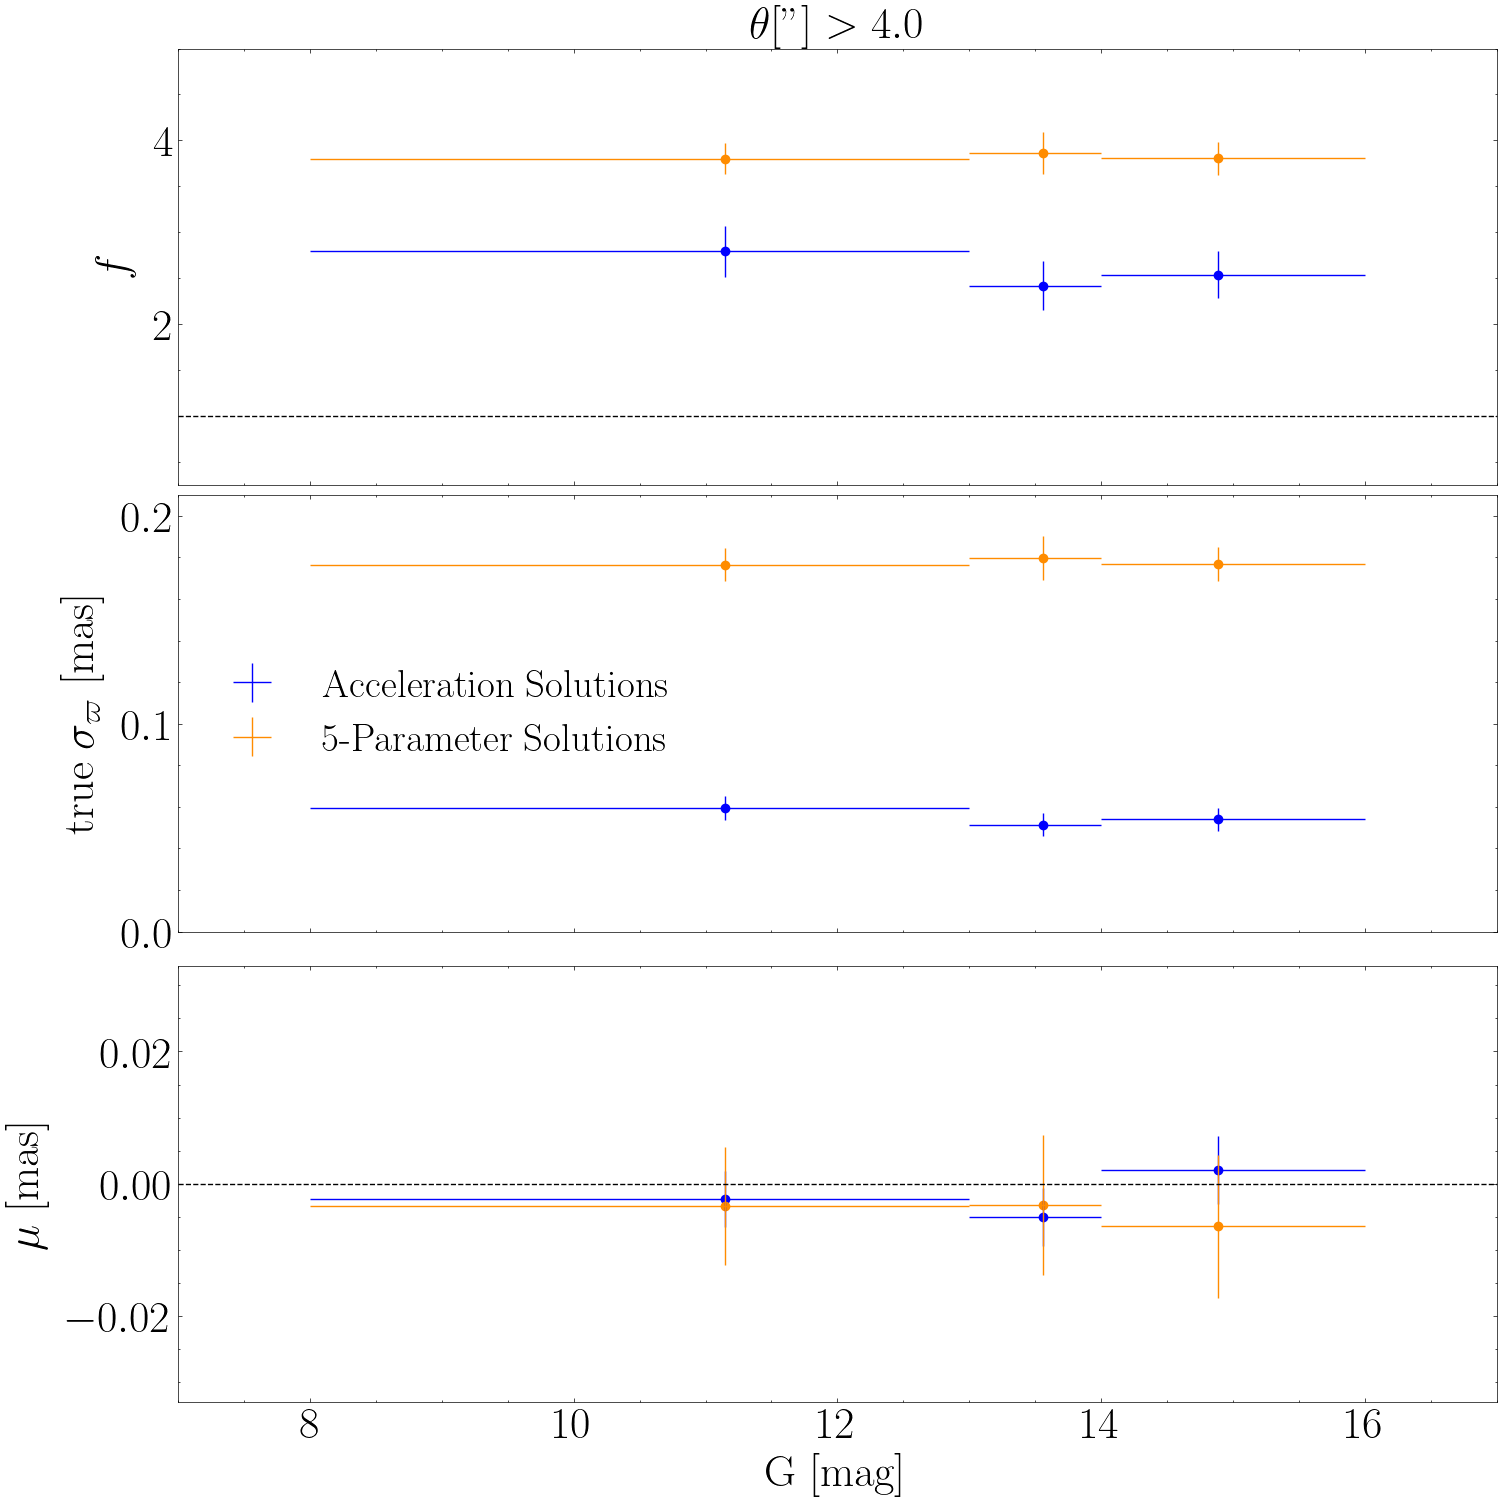

In [22]:
# Plot best-fit parameters and true uncertainties as a function of apparent G-band magnitude
acc_five_par_trend_fig, axes = plt.subplots(3, len(acc_ang_sep_bins) - 1, figsize = (15, 15), sharex = True, sharey = 'row', 
                                        layout = 'constrained')
axes = [[ax] for ax in axes]

for j in range(1, len(acc_ang_sep_bins)):
    if acc_ang_sep_bins[j] == np.inf:
        title_str = rf'$\theta ["] > {acc_ang_sep_bins[j - 1]}$'
    else:
        title_str = rf'${acc_ang_sep_bins[j - 1]} < \theta ["] < {acc_ang_sep_bins[j]}$'
        
    curr_ax = axes[0][j - 1]
    mean_Gs, G_errs = [], []
    for i in range(1, len(acc_G_mag_bins)):
        bin_Gs = acc_in_range_Gs[(acc_ang_sep_IDs == j) & (acc_G_mag_IDs == i)]
        mean_Gs.append(np.mean(bin_Gs))
        G_errs.append([np.mean(bin_Gs) - acc_G_mag_bins[i - 1], acc_G_mag_bins[i] - np.mean(bin_Gs)])
    G_errs = np.array(G_errs)
    curr_ax.scatter(mean_Gs, all_acc_fs[j - 1], color = 'blue')
    curr_ax.errorbar(mean_Gs, all_acc_fs[j - 1], xerr = G_errs.T, yerr = all_acc_f_errs[j - 1], linestyle = 'none', color = 'blue', 
                     label = 'Accelerating Solutions')
    curr_ax.scatter(mean_Gs, all_acc_five_par_fs[j - 1], color = 'darkorange')
    curr_ax.errorbar(mean_Gs, all_acc_five_par_fs[j - 1], xerr = G_errs.T, yerr = all_acc_five_par_f_errs[j - 1], linestyle = 'none', 
                     color = 'darkorange', label = '5-Parameter Solutions')
    curr_ax.tick_params(which = 'both', labelsize = 32)
    curr_ax.set_title(title_str, fontsize = 32)
    
    curr_ax = axes[1][j - 1]
    median_sigmas1, median_five_par_sigmas1 = [], []
    for i in tqdm(range(1, len(G_mag_bins))):
        sigmas1 = acc_in_range_sigmas1[(acc_ang_sep_IDs == j) & (acc_G_mag_IDs == i)]
        median_sigmas1.append(np.median(sigmas1))
        five_par_sigmas1 = acc_in_range_five_par_sigmas1[(acc_ang_sep_IDs == j) & (acc_G_mag_IDs == i)]
        median_five_par_sigmas1.append(np.median(five_par_sigmas1))
    median_sigmas1 = np.array(median_sigmas1)
    median_five_par_sigmas1 = np.array(median_five_par_sigmas1)
    curr_ax.scatter(mean_Gs, np.array(all_acc_fs[j - 1]) * median_sigmas1[j - 1], color = 'blue')
    curr_ax.errorbar(mean_Gs, np.array(all_acc_fs[j - 1]) * median_sigmas1[j - 1], xerr = G_errs.T, 
                     yerr = np.array(all_acc_f_errs[j - 1]) * median_sigmas1[j - 1], linestyle = 'none', color = 'blue', 
                     label = 'Acceleration Solutions')
    curr_ax.scatter(mean_Gs, np.array(all_acc_five_par_fs[j - 1]) * median_five_par_sigmas1[j - 1], color = 'darkorange')
    curr_ax.errorbar(mean_Gs, np.array(all_acc_five_par_fs[j - 1]) * median_five_par_sigmas1[j - 1], xerr = G_errs.T, 
                     yerr = np.array(all_acc_five_par_f_errs[j - 1]) * median_five_par_sigmas1[j - 1], linestyle = 'none', 
                     color = 'darkorange', label = '5-Parameter Solutions')
    curr_ax.tick_params(which = 'both', labelsize = 32)
    
    curr_ax = axes[2][j - 1]
    curr_ax.scatter(mean_Gs, all_acc_mus[j - 1], color = 'blue')
    curr_ax.errorbar(mean_Gs, all_acc_mus[j - 1], xerr = G_errs.T, yerr = all_acc_mu_errs[j - 1], linestyle = 'none', color = 'blue', 
                     label = 'Acceleration Solutions')
    curr_ax.scatter(mean_Gs, all_acc_five_par_mus[j - 1], color = 'darkorange')
    curr_ax.errorbar(mean_Gs, all_acc_five_par_mus[j - 1], xerr = G_errs.T, yerr = all_acc_five_par_mu_errs[j - 1], linestyle = 'none', 
                     color = 'darkorange', label = '5-Parameter Solutions')
    curr_ax.tick_params(which = 'both', labelsize = 32)
    curr_ax.set_xlabel('G [mag]', fontsize = 32)

axes[0][0].set_xlim(7, 17)
axes[0][0].set_ylim(0.25, 5)
axes[0][0].hlines(1.0, axes[0][0].get_xlim()[0], axes[0][0].get_xlim()[1], linestyle = '--', color = 'black')

axes[1][0].set_ylim(0, 0.21)

axes[2][0].set_ylim(-0.033, 0.033)
axes[2][0].hlines(0.0, axes[0][0].get_xlim()[0], axes[0][0].get_xlim()[1], linestyle = '--', color = 'black')

axes[0][0].set_ylabel(r'$f$', labelpad = 12, fontsize = 32)
axes[1][0].set_ylabel(r'true $\sigma_{\varpi}$ [mas]', labelpad = 12, fontsize = 32)
axes[2][0].set_ylabel(r'$\mu$ [mas]', labelpad = 12, fontsize = 32)

# axes[0][0].legend(fontsize = 28, loc = 'lower left')
axes[1][0].legend(fontsize = 28, loc = 'center left');